In [1]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
from torchvision import datasets, transforms
import time
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Data Loading and Preparation

The following code snippet demonstrates the data loading and preparation process for the poultry disease classification task using PyTorch `DataLoader` and `ImageFolder` from the `datasets` module.

#### Parameters:
- `batch_size`: Set to 512 for batch processing during training and evaluation.
- `num_workers`: Configured with 4 workers to parallelize data loading for efficiency.
- `pin_memory`: Enabled to facilitate faster data transfer if using a GPU.

This setup ensures the efficient handling of data, enabling the training, validation, and evaluation of the poultry disease classification model using the specified datasets.

In [3]:
batch_size = 512
num_workers = 4
pin_memory = True  # Enable for faster data transfer if using GPU

dataset = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/train', transform=data_transforms)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
dataset_val = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/val', transform=data_transforms)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
dataset_test = datasets.ImageFolder(root='/kaggle/input/poultry-diseases/data/data/test', transform=data_transforms)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

### Viewing Samples from the Test Dataset

To visualize and inspect the images along with their corresponding labels from the train dataset, the following Python code utilizes Matplotlib. 

The iteration through the `train_loader` retrieves a batch of images (`images`) and their associated labels (`labels`). The function `imshow()` is defined to display images with their corresponding labels.


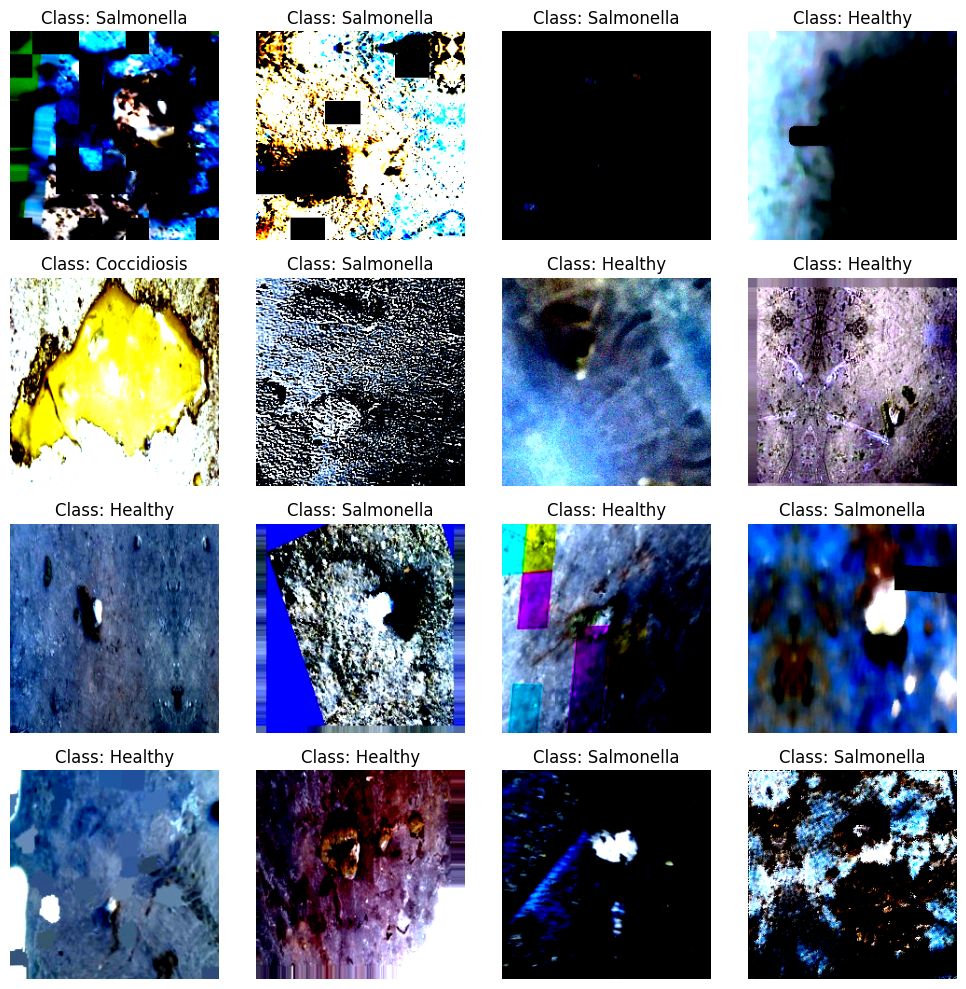

In [4]:
class_names = ["Coccidiosis", "Healthy", "New Castle Disease", "Salmonella"]

# Assuming 'images' contains the image data and 'labels' contains the corresponding labels
for images, labels in train_loader:
    # Function to display images with labels
    def imshow(img, title):
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    # Displaying 16 images in a 4x4 grid
    plt.figure(figsize=(10, 10))
    for idx in range(16):
        plt.subplot(4, 4, idx + 1)
        # Get the class name corresponding to the label
        class_label = class_names[labels[idx]]
        imshow(images[idx], f"Class: {class_label}")  # Display class name as title
    plt.tight_layout()
    plt.show()
    break  # Only display one batch of images for brevity

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Check for the availability of GPUs
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available, training on CPU")

GPU 0: Tesla T4
GPU 1: Tesla T4


### ResNet-18 Model Configuration

This snippet initializes a ResNet-18 model for poultry disease classification. Key steps include:
- Using `resnet18` with default weights to create the model.
- Allowing parameter fine-tuning during training.
- Modifying the output layer for 4 classes.
- Configuring multi-GPU training for enhanced performance.
- Moving the model to the specified device (e.g., GPU) for computation.

This setup readies the ResNet-18 architecture for efficient training and classification of poultry diseases.

In [6]:
if not os.path.exists("resnet18"):
    os.mkdir("resnet18")

#weights_path = "/kaggle/input/<dataset-folder>/resnet18-f37072fd.pth"
weights_path = "/kaggle/input/resnet18-f37072fd/resnet18-f37072fd.pth"
model = resnet18()
model.load_state_dict(torch.load(weights_path))

# Define ResNet-18 model
#model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training Setup: Loss, Optimizer, and Scheduler

This code block defines:
- **Loss Function:** Cross-Entropy Loss suitable for multi-class classification tasks.
- **Optimizer:** AdamW optimizer with a learning rate of 0.001 and weight decay for model updates.
- **Scheduler:** Reduces the learning rate on plateaus to optimize training efficiency.

These settings configure the training process by specifying the loss calculation, optimizer for updating model weights, and a scheduler to dynamically adjust the learning rate.

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, factor=0.2, min_lr=1e-5)

### Training Loop with Validation and Logging

In [8]:
num_epochs = 15
best_val_accuracy = 0.0


csv_filename = "resnet18/training_log.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy", "Time (s)"])

# Initialize variables for best model tracking
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy for this epoch
    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy for this epoch
    val_accuracy = 100 * correct_val / total_val
    scheduler.step(val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time

    # Print and log epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, " 
          f"Val Loss: {val_loss/len(val_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

    # Log results to CSV file
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, running_loss/len(train_loader), val_loss/len(val_loader), train_accuracy, val_accuracy, epoch_time])

    # Check if this is the best model so far based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_epoch = epoch + 1
        # Save the best model checkpoint
        best_model_path = f"resnet18/best.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, best_model_path)

torch.save(model.state_dict(), "resnet18/last.pt")
print("Training complete")

Epoch 1/15, Training Loss: 0.2389, Val Loss: 0.1891, Train Accuracy: 90.98%, Val Accuracy: 92.89%, Time: 1406.23 seconds
Epoch 2/15, Training Loss: 0.1511, Val Loss: 0.1922, Train Accuracy: 94.30%, Val Accuracy: 92.84%, Time: 1373.91 seconds
Epoch 3/15, Training Loss: 0.1181, Val Loss: 0.1719, Train Accuracy: 95.56%, Val Accuracy: 93.75%, Time: 1367.18 seconds
Epoch 4/15, Training Loss: 0.0949, Val Loss: 0.1614, Train Accuracy: 96.43%, Val Accuracy: 94.31%, Time: 1363.90 seconds
Epoch 5/15, Training Loss: 0.0777, Val Loss: 0.1577, Train Accuracy: 97.07%, Val Accuracy: 94.64%, Time: 1365.56 seconds
Epoch 6/15, Training Loss: 0.0641, Val Loss: 0.1616, Train Accuracy: 97.60%, Val Accuracy: 94.86%, Time: 1357.46 seconds
Epoch 7/15, Training Loss: 0.0546, Val Loss: 0.1768, Train Accuracy: 97.97%, Val Accuracy: 94.60%, Time: 1355.76 seconds
Epoch 8/15, Training Loss: 0.0442, Val Loss: 0.1736, Train Accuracy: 98.36%, Val Accuracy: 94.73%, Time: 1387.98 seconds
Epoch 00009: reducing learning r

### Visualizing Model Training Metrics

This code snippet processes a CSV file storing model training metrics such as epoch, train loss, validation loss, train accuracy, validation accuracy, and time taken per epoch.

The Python code reads the CSV using Pandas, organizing the data into a DataFrame. It then employs Matplotlib to create two informative plots:
- **Train and Validation Loss**: Depicts how the training and validation losses evolve with each epoch, providing insights into the model's learning progress and potential overfitting.
- **Train and Validation Accuracy**: Illustrates the changes in training and validation accuracies across epochs, offering an understanding of the model's learning performance.


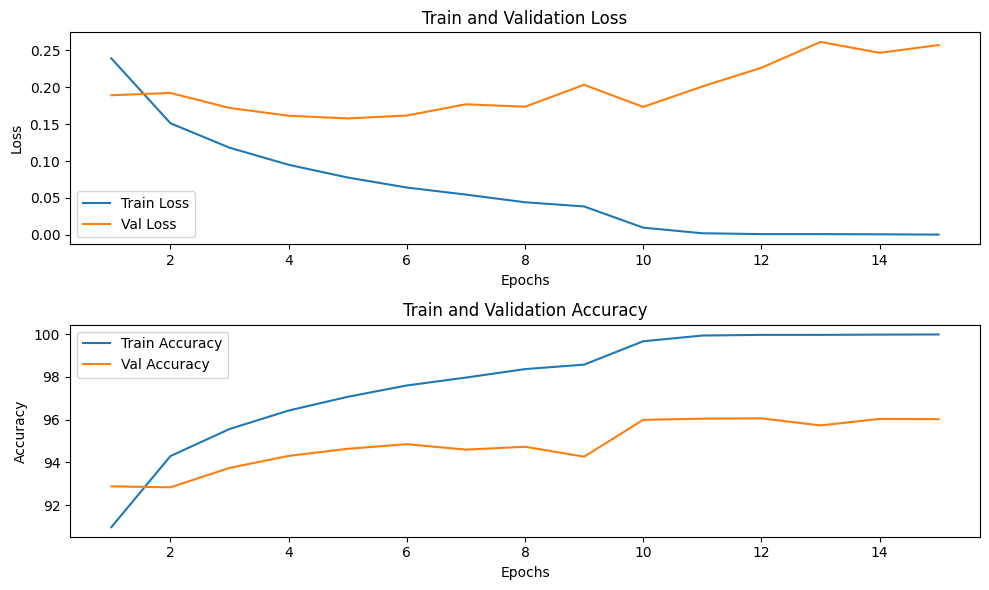

In [9]:
data = pd.read_csv(csv_filename)

# Extract data columns
epochs = data['Epoch']
train_loss = data['Train Loss']
val_loss = data['Val Loss']
train_accuracy = data['Train Accuracy']
val_accuracy = data['Val Accuracy']
time_seconds = data['Time (s)']

# Plotting
plt.figure(figsize=(10, 6))

# Train and Validation Loss Plot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Train and Validation Accuracy Plot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation on Test Data

In this section, the trained ResNet-18 model is evaluated using the test dataset to assess its performance on unseen data.

In [10]:
# Testing
model.eval()
class_labels = dataset.classes
correct_test = 0
total_test = 0
test_loss = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2513, Test Accuracy: 96.09%


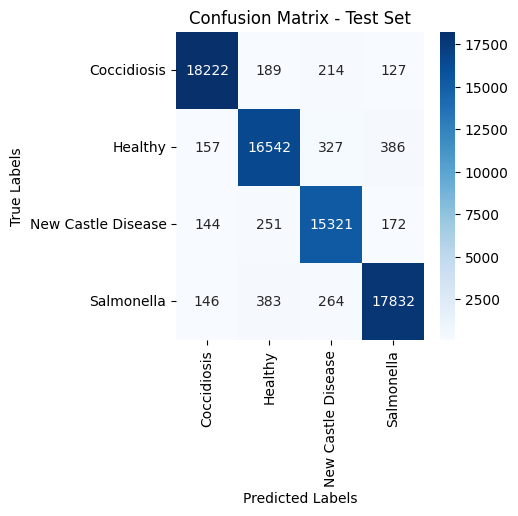

Confusion matrix saved as confusion_matrix.png


In [11]:
# Compute and plot the confusion matrix for the final test set
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set")
plt.savefig("resnet18/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("Confusion matrix saved as confusion_matrix.png")

In [12]:
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                    precision    recall  f1-score   support

       Coccidiosis       0.98      0.97      0.97     18752
           Healthy       0.95      0.95      0.95     17412
New Castle Disease       0.95      0.96      0.96     15888
        Salmonella       0.96      0.96      0.96     18625

          accuracy                           0.96     70677
         macro avg       0.96      0.96      0.96     70677
      weighted avg       0.96      0.96      0.96     70677



### Conclusion

This implementation demonstrates a sample approach to poultry disease classification using the ResNet-18 model. Achieving a peak test accuracy of 96.09% on the test dataset, this model showcases robust performance in accurately identifying poultry diseases based on fecal images.

This methodology serves as a sample framework that can be similarly employed with other powerful models such as DenseNet, VGG, or custom architectures. By exploring alternative architectures and fine-tuning hyperparameters, further advancements and improvements in disease classification accuracy can be pursued within the domain of poultry pathology.
